# Visualization 

## TODO: k-NN + directed version (direction = style)

In [1]:
import numpy as np
import time
import datetime 
import json
from tqdm import tqdm
import os
import tensorflow as tf
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from bokeh.io import output_notebook
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
output_notebook()

import data_utils_LMR
from data_utils_LMR import prepare_data,read_data, EncoderDecoder
from model import Vrae as Vrae_model
from batch import Generator

training_dir = 'logs/'
#training_dir += 'state1024_layers2_latent16_batch256_LSTM_seqs15-30_8e-3'
#training_dir += 'state1024_layers2_latent16_batch256_LSTM_seqs15-30_8e-3_d0.5'
#training_dir += state300_layers5_latent16_batch256_LSTM_seqs15-30_8e-3_B0.01_f32
#training_dir += '6layers_UGRNN_small'
#training_dir += '4layers_UGRNN'
training_dir += 'sentiment_input_deep'

# sentiment analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentimentAnalyzer = SentimentIntensityAnalyzer()
def getSentimentScore(sentence):
    scores = sentimentAnalyzer.polarity_scores(sentence)
    return (scores['neg'], scores['neu'] ,scores['pos'])

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
with open(training_dir +'/flags.json', 'r') as fp:
    FLAGS = dotdict(json.loads( fp.read() ) )
    
for k,v in FLAGS.iteritems():
    print k,':',v
      
n_samples = 5000#int(FLAGS.batch_size)

Loading BokehJS ...

sequence_max : 30
decoder_num_layers : 2
beta_period : 100
training_dir : logs/sentiment_input_deep
epoches : 10000
batch_size : 1048
char2word_num_layers : 2
initialize : True
teacher_forcing : True
learning_rate_change_rate : 3000
beta_offset : 15
encoder_num_layers : 1
char2word_state_size : 512
sequence_min : 8
latent_dim : 16
dtype_precision : 32
cell : LSTM
use_sentiment_feature : True
initial_learning_rate : 0.001
decoder_state_size : 1024
output_keep_prob : 0.5
acceptable_accuracy : 0.4
peephole : True
input_keep_prob : 0.9
encoder_state_size : 1024
latent_loss_weight : 0.005


/home/ubuntu/anaconda2/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Prepare data

Data already downloaded.
Creating Vocabulary..
Vocabulary already created.
Converting sentences to sequences of ids..
Moving some line from test set to train set..
  reading data line 10000
  reading data line 20000
  reading data line 30000
37109  sentences


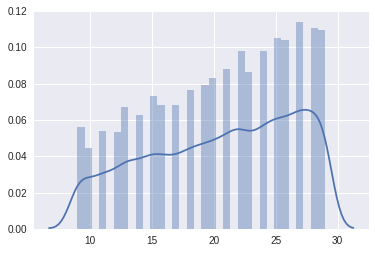

In [2]:
with open(training_dir +'/training_parameters.json', 'r') as fp:
    training_parameters = json.loads( fp.read() )
# vocabulary encoder-decoder
encoderDecoder = EncoderDecoder()
num_symbols = encoderDecoder.vocabularySize()
# prepare data
prepare_data(1000)
sentences, ratings = read_data( max_size=None, 
                               max_sentence_size=training_parameters['seq_max'],
                               min_sentence_size=int(FLAGS.sequence_min), 
                               test=False) 
print len(sentences), " sentences"
if len(sentences) < n_samples:
    n_samples = len(sentences) - 1
sns.distplot( [len(sent) for sent in sentences])
plt.show()

## Loading models

In [ ]:
space_symbol = encoderDecoder.encode("I am")[1]
word_delimiters = [ data_utils_LMR._EOS, data_utils_LMR._GO, space_symbol ]
batch_gen = Generator(sentences, ratings, n_samples, word_delimiters)
num_iters = FLAGS.epoches * batch_gen.iterations_per_epoch()
# text decoder ( text <-> ids)
encoderDecoder = EncoderDecoder()

config = tf.ConfigProto(
        device_count = {'GPU': 0}, # do not use GPU for testing
    )

# load model
vrae_model = Vrae_model(char2word_state_size = int(FLAGS.char2word_state_size), 
                     char2word_num_layers = int(FLAGS.char2word_num_layers), 
                     encoder_state_size = int(FLAGS.encoder_state_size), 
                     encoder_num_layers = int(FLAGS.encoder_num_layers), 
                     decoder_state_size = int(FLAGS.decoder_state_size), 
                     decoder_num_layers = int(FLAGS.decoder_num_layers), 
                          latent_dim=int(FLAGS.latent_dim),
                         batch_size=n_samples,
                         num_symbols=num_symbols,
                        latent_loss_weight=float(FLAGS.latent_loss_weight),
                         dtype_precision=FLAGS.dtype_precision,
                        cell_type=FLAGS.cell, 
                        peephole=FLAGS.peephole,
                        input_keep_prob=float(FLAGS.input_keep_prob),
                        output_keep_prob=float(FLAGS.output_keep_prob),
                      sentiment_feature = bool(FLAGS.use_sentiment_feature)
                       )

def zToXdecoded(session,z_sample,s_length):
    x_reconstruct = vrae_model.zToX(session,z_sample,s_length)
    return encoderDecoder.prettyDecode( np.argmax(x_reconstruct[0], axis= 1) ) 

## Generating test data

In [ ]:
saver = tf.train.Saver()
#print train_dir
np.random.seed(13)
batch_gen.shuffle()
samples = []
with tf.Session(config=config) as sess:
    saver.restore(sess, "./"+training_dir+'/model.ckp')
    print
    padded_batch_xs, batch_ys, batch_lengths, batch_weights, end_of_words, batch_word_lengths, max_length  = batch_gen.next_batch()
    vaderSentiments = [ getSentimentScore(encoderDecoder.prettyDecode(xx)) for xx in padded_batch_xs]
    x_reconstruct,z_vals,z_mean_val,z_log_sigma_sq_val, losses  = vrae_model.reconstruct( sess, 
                                                                                         padded_batch_xs,batch_lengths, 
                                                                                         batch_weights, 
                                                                                         end_of_words, 
                                                                                         batch_word_lengths,
                                                                                        vaderSentiments)
print "Done!"    

INFO:tensorflow:Restoring parameters from ./logs/sentiment_input_deep/model.ckp



In [ ]:
print losses

In [ ]:
vaderSentiments = [ getSentimentScore(encoderDecoder.prettyDecode(padded_batch_xs[i])) for i in xrange(n_samples)]

## Reconstruction

In [ ]:
#np.random.seed(13)
for i in range(10):
    i = int(np.random.random()*n_samples)
    i = i
    print "sentiment:", vaderSentiments[i],"| rating:", batch_ys[i]
    print encoderDecoder.prettyDecode( padded_batch_xs[i] )
    print encoderDecoder.prettyDecode( np.argmax(x_reconstruct[i], axis= 1) )
    print "------------------------------------------"

## Reconstruction in the Latent Space

In [ ]:
# dimension reduction
from sklearn.manifold import TSNE
X = np.array(z_vals)
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
zs_reduced = model.fit_transform(X) 
xs = [ zs_reduced[i,0] for i in xrange(n_samples) ]
ys = [ zs_reduced[i,1] for i in xrange(n_samples) ]

In [ ]:
from bokeh.layouts import column
from bokeh.models import CustomJS, ColumnDataSource, Select
from bokeh.plotting import figure, output_file, show
!export BOKEH_LOG_LEVEL=error
output_file("latent_space.html")

inputs = [encoderDecoder.prettyDecode(x) for x in padded_batch_xs]
M =max(batch_lengths)
binary_rating = [ int(r > 5) for r in batch_ys]
colors_sent = [ "#%02x%02x%02x" % ( 100 + 150 * r[0] ,  100 + 150 * r[2]  , 100 + 100 * r[1]  ) for r in vaderSentiments ]
color_rating = [ "#%02x%02x%02x" % (255 * (1-r) , 100, 255*r) for r in binary_rating ]
colors_lengths = [ "#%02x%02x%02x" % (  ( 255 * (float(r)/float(M))), 50, 255 - 255 * (float(r)/float(M)))  for r in batch_lengths ]
hasQuestionMark = [ int("?" in x) for x in inputs]
colors_questionMark = ["#%02x%02x%02x" % (255 * (1-r) , 100, 255*r) for r in hasQuestionMark]
is_past_voice = [ int("was" in x) or int("were" in x) or int("did" in x) or int("had" in x) for x in inputs]
colors_past = ["#%02x%02x%02x" % (255 * (1-r) , 100, 255*r) for r in is_past_voice]

source = ColumnDataSource(
        data=dict(
            x=xs,
            y=ys,
            input=inputs,
            output= [encoderDecoder.prettyDecode(np.argmax(y, axis= 1) ) for y in x_reconstruct],
            rating=batch_ys,
            sent= vaderSentiments,
            rating_color=color_rating,
            sentiment_color=colors_sent,
            lenght_color=colors_lengths,
            questionMark_color=colors_questionMark,
            past_color = colors_past,
            lengths=batch_lengths,
        )
    )


hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("input", "@input"),
            ("output", "@output"),
            ("rating", "@rating"),
            ("lengths", "@lengths"),
        ]
    )

p = figure(plot_width=800, plot_height=600, tools=[hover],title="Latent space")
cir = p.circle('x', 'y', size=9, source=source, fill_color="sentiment_color", alpha=0.8)

callback = CustomJS(args=dict(cir=cir,source=source), code="""
        var selected_color = cb_obj.value;
        selected_color = selected_color
        console.log(selected_color);
        cir.glyph.line_color.field = selected_color;
        cir.glyph.fill_color.field = selected_color;
        source.trigger("change")
    """)


select = Select(title="Color:", value="sentiment", options=["sentiment_color", "rating_color", "lenght_color", "questionMark_color", "past_color"], callback=callback)


layout = column(select, p)

show(layout)

## Sentiment Distribution

In [ ]:
import seaborn as sns
cols = sns.color_palette()
pos = []
neg = []
neu = []
major_sent = np.argmax(vaderSentiments, axis = 1)
for i in xrange(n_samples):
    if major_sent[i] == 2:
        pos.append( z_mean_val[i,:] )
    elif major_sent[i] == 0:
        neg.append( z_mean_val[i,:] )
    else:
        neu.append( z_mean_val[i,:] )

print len(pos), "positive sentences"
print len(neg), "negative sentences"
print len(neu), "neutral sentences"

pos = np.array(pos)
neg = np.array(neg)
neu = np.array(neu)

side_lenght = int(np.sqrt(int(FLAGS.latent_dim)))
if side_lenght**2 < int(FLAGS.latent_dim):
    side_lenght +=1
f, axs = plt.subplots(ncols=side_lenght, nrows=side_lenght, sharey=True, figsize=(10, 10))
for i in xrange(side_lenght):
    for j in xrange(side_lenght):
        k = i*side_lenght+j
        if k < int(FLAGS.latent_dim):
            sns.distplot( neu[:,k], ax=axs[i,j], hist=False, color= cols[0] )
            sns.distplot( pos[:,k], ax=axs[i,j], hist=False, color= cols[1] )
            sns.distplot( neg[:,k], ax=axs[i,j], hist=False, color= cols[2])
plt.show()

## The Sentiment Dimension

In [ ]:
import scipy
import random

KLs = []
for k in xrange(int(FLAGS.latent_dim)):
    a = list(neg[:,k])
    b = list(pos[:,k])
    kl = np.abs( np.mean(a) - np.mean(b))
    
    KLs.append( kl )

sorted_kls = sorted( enumerate(KLs) , key = lambda x: x[1], reverse=True )
for k,kl in sorted_kls:
    print k,kl

In [ ]:
k=sorted_kls[0][0]
sns.distplot( neu[:,k], hist=False, color= cols[0] )
sns.distplot( pos[:,k], hist=False, color= cols[1] )
sns.distplot( neg[:,k], hist=False, color= cols[2])
plt.show()

In [ ]:
ks = sorted_kls[0][:3]
dx = 2

saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    saver.restore(sess, "./"+training_dir+'/model.ckp')
    u0 = "I like this movie."
    u1 = "I recommend this movie."
    u = u0
    #print u
    z0 = vrae_model.XToz(sess, *encoderDecoder.encodeForTraining(u), sentiment=getSentimentScore(u))[0]
    #z0 = np.zeros(int(FLAGS.latent_dim))
    dz = np.zeros(int(FLAGS.latent_dim))
    dz[k] = dx
    z1 = z0 + dz
    z2 = z0 - dz
    print "distance between two points:",np.linalg.norm(z2-z1),"\n"
    zs = []
    for t in np.linspace(0,1,30):
        zs.append( (1-t) * z1 + t * z2 )

    for z_ in zs:
        print zToXdecoded(sess, z_ , 45 )

## Dimension pairplot

cross check dimensions

In [ ]:
import pandas as pd 
major_sent = np.argmax(vaderSentiments, axis = 1)
sent_df = pd.DataFrame( z_mean_val )
sent_df['major_sent'] = major_sent
#sns.pairplot(sent_df, hue='major_sent', diag_kind="kde")
#plt.show()

## Continuous space: Homotopy

In [ ]:
saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    saver.restore(sess, "./"+training_dir+'/model.ckp')
    print
    
    # show interpolations
    u0 = ["I loved it." , "I hated this film."]
    u01 = ["I loved it." , "It was terrible."]
    u1 = ["I loved this movie!.", "I hated this movie!"]
    u2 = ["The best movie I've seen!", "The worst movie ever made."]
    u3 = ["great movie.", "terrible movie."]
    u4 = ["that's actually pretty good." , "That was a failure."]
    u5 = ["I didn't laugh at all.", "I wanted to love this movie."]
    u6 = ["so bad that it's really bad" , "Where is the acting?"]
    u7 = ["I love old movies.", "I prefer old movies."]
    u8 = ["the music is very bad.", "the music is just awful."]
    u9 = ["awesome!", "terrible."]
    u10 = ["awful." , "pretty worthless."]
    u11 = ["yes you do." , "no you don't."]
    u12 = ["The acting was really bad." , "The acting was really good!"]
    u13 = ["This film was fascinatingly stupid." , "This is an excellent film."]
    u14 = ["I don't recommend it to anyone.", "This is a really really bad movie."]
    u = u10
    z1 = vrae_model.XToz(sess, *encoderDecoder.encodeForTraining(u[0]),sentiment=getSentimentScore(u[0]))[0]
    z2 = vrae_model.XToz(sess, *encoderDecoder.encodeForTraining(u[1]),sentiment=getSentimentScore(u[1]))[0]
    #z1 = np.zeros(16)
    #z2 = 0.1 * np.ones(16)
    print "distance between two points:",np.linalg.norm(z2-z1),"\n"
    zs = []
    for t in np.linspace(0,1,20):
        zs.append( (1-t) * z1 + t * z2 )

    for z_ in zs:
        print zToXdecoded(sess, z_ , 45 )

## Reconstruction: Reconstructing using Model's knowledge

In [ ]:
saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    saver.restore(sess, "./"+training_dir+'/model.ckp')
    u0 = "I like this movie."
    u1 = "It was terrible."
    u2 = "I recommend it."
    u3 = "I loved it."
    us = [u0,u1,u2,u3]
    for u in us:
        z = vrae_model.XToz(sess, *encoderDecoder.encodeForTraining(u), sentiment=getSentimentScore(u))[0]
        print u, "->",
        print zToXdecoded(sess,z,40)

## Vector Translations

In [ ]:
saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    saver.restore(sess, "./"+training_dir+'/model.ckp')
    print
    
    # show interpolations
    a = "I liked it."
    b = "I didn't like it."
    c = "I recommend this movie."
    
    
    #a = "it was terrible."
    #b = "it was not good."
    #c = "Id didn't like it."
    
    #a = "I love this movie!"
    #b = "I like this movie."
    #c = "I love the acting!"
    
    za = vrae_model.XToz(sess, *encoderDecoder.encodeForTraining(a), sentiment=getSentimentScore(a) )[0]
    zb = vrae_model.XToz(sess, *encoderDecoder.encodeForTraining(b), sentiment=getSentimentScore(b))[0]
    zc = vrae_model.XToz(sess, *encoderDecoder.encodeForTraining(c), sentiment=getSentimentScore(c))[0]
    
    # translation
    zd = zc + (zb - za)
    print "a \t\t|", a,"|", zToXdecoded(sess, za , 40 )
    print "b \t\t|", b,"|", zToXdecoded(sess, zb , 40 )
    print "c \t\t|", c,"|", zToXdecoded(sess, zc , 40 )
    print
    print "c + b-a \t|", zToXdecoded(sess, zd , 40 )

## Neighborhood

In [ ]:
saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    saver.restore(sess, "./"+training_dir+'/model.ckp')
    print
    
    # show interpolations
    u1 = "That's actually pretty good."
    u2 = "I love it."
    u = u1
    z1 = vrae_model.XToz(sess, *encoderDecoder.encodeForTraining(u), sentiment=getSentimentScore(u))[0]
    print z1
    print
    r = 1
    zs = []
    for t in range(50):
        z2 = [ z_ + r * np.random.random() for z_ in z1  ]
        zs.append( z2)

    for z_ in zs:
        print zToXdecoded(sess, z_ , 40 )

$$\log p(x) =  \sum_{i=1}^N q(z^{(i)} | x ) \log p(x)$$


$$ \sum_{i=1}^N q(z^{(i)} | x ) \left [    \frac{q_\phi(z^{(i)} | x) p_\theta(x,z)}{p_\theta(z|x^{(i)}) q_\phi(z^{(i)} | x) }    \right ] $$
   
   
$$ \sum_{i=1}^N q(z^{(i)} | x ) \log \frac{q(z^{(i)} | x )}{p_\theta(z|x^{(i)})} + q(z^{(i)} | x ) \log p_\theta(x,z) - q(z^{(i)} | x ) log q(z^{(i)} | x ) $$


$$ D_{KL} (q(z^{(i)} | x ) || p_\theta(z|x^{(i)})) + E_{q(z^{(i)} | x )} [- \log q(z^{(i)} | x ) + \log p_\theta (x,z)] $$

In [199]:
 & = \sum_{i=1}^N q(z^{(i)} | x ) \left [    \frac{q_\phi(z^{(i)} | x) p_\theta(x,z)}{p_\theta(z|x^{(i)}) q_\phi(z^{(i)} | x) }    \right ]  \\
    & = \sum_{i=1}^N q(z^{(i)} | x ) \log \frac{q(z^{(i)} | x )}{p_\theta(z|x^{(i)})} + q(z^{(i)} | x ) \log p_\theta(x,z) - q(z^{(i)} | x ) log q(z^{(i)} | x ) \\
    & = D_{KL} (q(z^{(i)} | x ) || p_\theta(z|x^{(i)})) + E_{q(z^{(i)} | x )} [- \log q(z^{(i)} | x ) + \log p_\theta (x,z)]

SyntaxError: invalid syntax (<ipython-input-199-5662f678ed41>, line 1)

$$ \mathcal{L} (\theta , \phi ; \theta^{(i)})  = E_{q_\phi(z| x^{(i)} )} [- \log q_\phi( | x^{(i)} ) + \log p_\theta (x^{(i)},z)] $$

$$- D_{KL} ( q_\phi(z | x^{(i)} ) || p_\theta(z) ) + E_{q_\phi(z| x^{(i)} )} [ \log p_\theta(x^{(i)} | z)]$$